In [1]:
import numpy as np

# import vunet
# import vunet_simple as vunet
import vunet_1 as vunet

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam

import h5py
import datetime

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap('jet')

<Figure size 432x288 with 0 Axes>

In [3]:
import tensorflow as tf
from keras import backend as K

# tf.session specification
# TensorFlow wizardry
config = tf.ConfigProto()

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.85

# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

#### Load/select data

In [4]:
model_string = 'vunet'
output_dir = 'saved_models/'
case_string = 'horizontal_16w'
data_dir = '/data/cees/zjin/cs231n/project/var-unet/data/'

In [5]:
# hf_r = h5py.File(data_dir + case_string + '.hdf5', 'r')
hf_r = h5py.File(data_dir + case_string + '_aug.hdf5', 'r') # augmented data
data_train = np.array(hf_r.get('data_train'))
data_eval = np.array(hf_r.get('data_eval'))
hf_r.close()

print(data_train.shape)
print(data_eval.shape)

(1800, 128, 128, 3, 2)
(200, 128, 128, 3, 2)


In [6]:
n_trial_data = 1800
data_train_trial = data_train[:n_trial_data,...]
print(data_train_trial.shape)


n_eval_data = 200
data_eval_trial = data_eval[:n_eval_data,...]
print(data_eval_trial.shape)

(1800, 128, 128, 3, 2)
(200, 128, 128, 3, 2)


#### Visualize input data

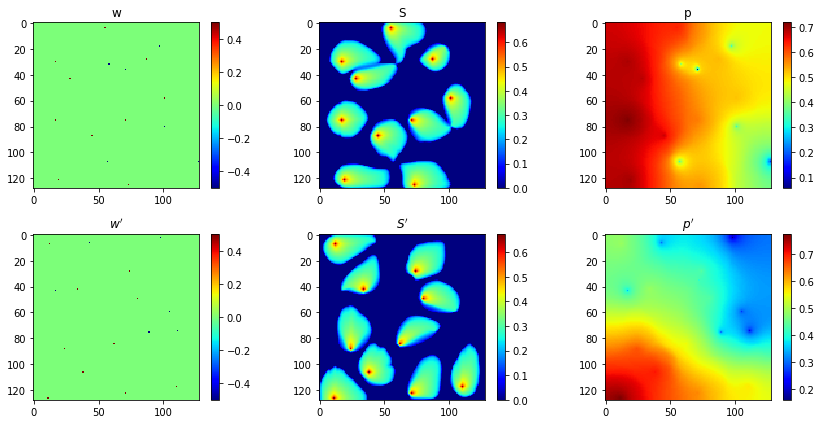

In [7]:
for k in range (1):
    plt.figure(figsize=(12, 6))
    #
    plt.subplot(2,3,1)
    plt.imshow(data_train_trial[k,...,0, 0])
    plt.title('w')
    plt.colorbar(fraction=0.046)
    #
    plt.subplot(2,3,2)
    plt.imshow(data_train_trial[k,...,1, 0])
    plt.title('S')
    plt.colorbar(fraction=0.046)
    #
    plt.subplot(2,3,3)
    plt.imshow(data_train_trial[k,...,2, 0])
    plt.title('p')
    plt.colorbar(fraction=0.046)
    #
    plt.subplot(2,3,4)
    plt.imshow(data_train_trial[k,...,0, 1])
    plt.title('$w^{\prime}$')
    plt.colorbar(fraction=0.046)
    #
    plt.subplot(2,3,5)
    plt.imshow(data_train_trial[k,...,1, 1])
    plt.title('$S^{\prime}$')
    plt.colorbar(fraction=0.046)
    #
    plt.subplot(2,3,6)
    plt.imshow(data_train_trial[k,...,2, 1])
    plt.title('$p^{\prime}$')
    plt.colorbar(fraction=0.046)
    plt.tight_layout()
    plt.show()

#### Re-organize data

In [8]:
# data_train_trial shape (?, 128, 128, 3, 2)
train_x_y_hat0 = data_train_trial[..., 0]# xc
train_y_hat0 = data_train_trial[..., [0], 1] #c
train_x_hat0 = data_train_trial[..., 1:, 1] # x

print(train_x_y_hat0.shape)
print(train_y_hat0.shape)
print(train_x_hat0.shape)

eval_x_y_hat0 = data_eval_trial[..., 0]# xc
eval_y_hat0 = data_eval_trial[..., [0], 1] #c
eval_x_hat0 = data_eval_trial[..., 1:, 1] # x

print(eval_x_y_hat0.shape)
print(eval_y_hat0.shape)
print(eval_x_hat0.shape)

# eval_x_y_hat0, eval_y_hat0, eval_x_hat0

(1800, 128, 128, 3)
(1800, 128, 128, 1)
(1800, 128, 128, 2)
(200, 128, 128, 3)
(200, 128, 128, 1)
(200, 128, 128, 2)


#### Train forward pass v-unet

In [9]:
input_shape = (128, 128, 3) # [S,p,w], the old saturation, pressure and well location
w_shape = (128, 128, 1) # [w'], the new well location and injection/production time
output_shape = (128, 128, 2) # [S', p'], the new saturation and pressure

reload if necessary

In [11]:
# from importlib import reload
# reload(vunet)

<module 'vunet_1' from '/data/cees/zjin/cs231n/project/var-unet/vunet_1.py'>

In [10]:
# change the role of enc_up and dec_up
# model specifications
n_res_block = 1
n_low_res = 6
n_scales = 5

enc_up, hidden_shapes = vunet.create_enc_up(w_shape, n_scales = n_scales)
enc_down = vunet.create_enc_down(hidden_shapes[-1])
dec_up = vunet.create_dec_up(input_shape, n_scales = n_scales) # only c input
dec_down = vunet.create_dec_down(hidden_shapes, hidden_shapes[-1], output_shape, n_scales = n_scales,  n_low_res = n_low_res)

In [11]:
# save inital weights
enc_up.save_weights(output_dir + 'enc_up_init_' + case_string + '.h5' )
enc_down.save_weights(output_dir + 'enc_down_init_' + case_string + '.h5' )
dec_up.save_weights(output_dir + 'dec_up_init_' + case_string + '.h5' )
dec_down.save_weights(output_dir + 'dec_down_init_' + case_string + '.h5' )

In [12]:
xc = Input(shape=input_shape) # perm + well location
c = Input(shape=w_shape) # well location

hs = enc_up(c)
z_posterior_sample, z_posterior_mean = enc_down(hs[-1])
gs = dec_up(xc)
x_hat, z_piror_sample, z_piror_mean = dec_down([z_posterior_mean, *gs])

In [13]:
def likelihood_loss(x, x_hat):
    '''
    Reconstruction loss, L2 norm
    
    '''
    v = 0.1
    return K.mean(K.sum((K.batch_flatten(x) - K.batch_flatten(x_hat)) ** 2 / (2*v), axis=-1))

def latent_kl_loss(q, p):
    mean1 = q
    mean2 = p
    
    kl = 0.5 * (mean2 - mean1)**2
    kl = K.sum(kl, axis = [1,2,3])
    kl = K.mean(kl)
    return kl

In [14]:
x = Input(shape=output_shape) # target saturation, pressure

likelihood_loss_value = likelihood_loss(x, x_hat)
kl_loss = latent_kl_loss(z_posterior_mean, z_piror_mean)
kl_weight = 5.0
total_loss = likelihood_loss_value + kl_weight * kl_loss


## Re-train start here

In [21]:
epoch = 40
learning_rate = 5e-4 # default 1e-3
decay = 1e-5 # default 1e-5
train_nr = data_train_trial.shape[0]
eval_nr = data_eval_trial.shape[0]

print('train_nr: ', train_nr)
print('eval_nr: ', eval_nr)

batch_size = 16
num_batch = int(train_nr/batch_size) 


train_nr:  1800
eval_nr:  200


In [22]:
# in case of re-training, load initial weights
enc_up.load_weights(output_dir + 'enc_up_init_' + case_string + '.h5')
enc_down.load_weights(output_dir + 'enc_down_init_' + case_string + '.h5')
dec_up.load_weights(output_dir + 'dec_up_init_' + case_string + '.h5')
dec_down.load_weights(output_dir + 'dec_down_init_' + case_string + '.h5')

In [23]:
opt = Adam(lr=learning_rate, decay=decay)

trainable_weights = enc_up.trainable_weights + enc_down.trainable_weights + dec_up.trainable_weights + dec_down.trainable_weights

updates = opt.get_updates(total_loss, trainable_weights)

iterate = K.function([xc, c, x], [total_loss, likelihood_loss_value, kl_loss], updates=updates)

eval_loss = K.function([xc, c, x], [total_loss])


In [24]:
## used to generate log directory
currentDT = datetime.datetime.now()
current_time = str(currentDT).replace(" ", "-")[:-10]
print(current_time)

2019-05-24-10:40


In [25]:
## log for tensorboard
def write_summary(value, tag, summary_writer, global_step):
    """
    Write a single summary value to tensorboard
    """
    summary = tf.Summary()
    summary.value.add(tag=tag, simple_value=value)
    summary_writer.add_summary(summary, global_step)

    
summary_writer = tf.summary.FileWriter('logs/' + model_string + '_bs%d_lr%.0e_ep%d_'%(batch_size, learning_rate, epoch)  + current_time)

In [26]:
for e in range(epoch):
    for ib in range(num_batch):
        ind0 = ib * batch_size
        n_itr = e * train_nr + ind0 + batch_size # for tensorboard output
        
        x_y_hat0_batch = train_x_y_hat0[ind0:ind0+batch_size, ...] #xc
        y_hat0_batch = train_y_hat0[ind0:ind0+batch_size, ...] # c: shape
        x_hat0_batch = train_x_hat0[ind0:ind0+batch_size, ...] # x
        
        train_losses = iterate([x_y_hat0_batch, y_hat0_batch, x_hat0_batch])
        ## -- K.function()
        ## -- Equivalent to:
        # train_losses = tf.session.run(feed_dict={xc: x_y_hat0_batch, c: y_hat0_batch, x: x_hat0_batch}, ...
        #                               fetches= [total_loss, likelihood_loss_value, kl_loss])
        # But output tensor for the updates operation is not returned.
        # For session.run(), the fetches should include a 'update' tensor, 
        # which is a tf operator that updates weights for each iteration.
        # Specifically, the 'update' tensor is defined as:
        # ---------------------------------
        # params = tf.trainable_variables()
        # gradients = tf.gradients(loss, params)
        # opt = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)
        # update = opt.apply_gradients(zip(gradients, params), global_step=global_step)
        # ---------------------------------
        # session.run() is with tf, and does not require Keras
        # K.function is a Keras API, which is more convient

        if ib % 10 == 0:
            print('Epoch %d/%d, Batch %d/%d, Total Loss %f, Likelihood Loss %f, KL Loss %f' % (e+1, epoch, ib+1, num_batch, train_losses[0], train_losses[1], train_losses[2]))
            write_summary(train_losses[0], 'train_loss', summary_writer, n_itr) # log for tensorboard
    
    eval_losses = eval_loss([eval_x_y_hat0, eval_y_hat0, eval_x_hat0])    
    write_summary(eval_losses[0], 'eval_loss', summary_writer, n_itr) # log for tensorboard
        

    print('====================================================')
    print('\n')
    print('Epoch %d/%d, Train Total Loss %f, Eval Total Loss %f' % (e + 1, epoch, train_losses[0], eval_losses[0]))
    print('\n')
    print('====================================================')

    
enc_up.save_weights(output_dir + 'enc_up_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
enc_down.save_weights(output_dir + 'enc_down_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
dec_up.save_weights(output_dir + 'dec_up_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
dec_down.save_weights(output_dir + 'dec_down_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))

Epoch 1/40, Batch 1/112, Total Loss 20087.867188, Likelihood Loss 20069.542969, KL Loss 3.664794
Epoch 1/40, Batch 11/112, Total Loss 8890.292969, Likelihood Loss 8888.192383, KL Loss 0.420200
Epoch 1/40, Batch 21/112, Total Loss 3952.966309, Likelihood Loss 3949.410156, KL Loss 0.711223
Epoch 1/40, Batch 31/112, Total Loss 4702.436523, Likelihood Loss 4699.467773, KL Loss 0.593710
Epoch 1/40, Batch 41/112, Total Loss 3348.333984, Likelihood Loss 3346.411133, KL Loss 0.384575
Epoch 1/40, Batch 51/112, Total Loss 3237.800781, Likelihood Loss 3236.492188, KL Loss 0.261742
Epoch 1/40, Batch 61/112, Total Loss 3258.707520, Likelihood Loss 3257.744141, KL Loss 0.192675
Epoch 1/40, Batch 71/112, Total Loss 3301.108643, Likelihood Loss 3300.177002, KL Loss 0.186335
Epoch 1/40, Batch 81/112, Total Loss 3253.669922, Likelihood Loss 3252.756348, KL Loss 0.182730
Epoch 1/40, Batch 91/112, Total Loss 3163.030029, Likelihood Loss 3161.806641, KL Loss 0.244698
Epoch 1/40, Batch 101/112, Total Loss 3

Epoch 7/40, Batch 31/112, Total Loss 1298.348511, Likelihood Loss 1277.261353, KL Loss 4.217436
Epoch 7/40, Batch 41/112, Total Loss 1021.952759, Likelihood Loss 1003.186157, KL Loss 3.753317
Epoch 7/40, Batch 51/112, Total Loss 1192.097412, Likelihood Loss 1177.243164, KL Loss 2.970858
Epoch 7/40, Batch 61/112, Total Loss 952.836670, Likelihood Loss 938.414368, KL Loss 2.884455
Epoch 7/40, Batch 71/112, Total Loss 974.704895, Likelihood Loss 959.532654, KL Loss 3.034449
Epoch 7/40, Batch 81/112, Total Loss 1194.347168, Likelihood Loss 1182.401855, KL Loss 2.389057
Epoch 7/40, Batch 91/112, Total Loss 1136.156128, Likelihood Loss 1120.854980, KL Loss 3.060240
Epoch 7/40, Batch 101/112, Total Loss 1064.579224, Likelihood Loss 1045.913940, KL Loss 3.733061
Epoch 7/40, Batch 111/112, Total Loss 956.966492, Likelihood Loss 943.119080, KL Loss 2.769479


Epoch 7/40, Train Total Loss 1098.130371, Eval Total Loss 1034.170288


Epoch 8/40, Batch 1/112, Total Loss 827.755249, Likelihood Loss 81

Epoch 13/40, Batch 71/112, Total Loss 450.544617, Likelihood Loss 436.944244, KL Loss 2.720073
Epoch 13/40, Batch 81/112, Total Loss 450.366547, Likelihood Loss 440.331421, KL Loss 2.007028
Epoch 13/40, Batch 91/112, Total Loss 643.598572, Likelihood Loss 626.715942, KL Loss 3.376524
Epoch 13/40, Batch 101/112, Total Loss 804.491638, Likelihood Loss 788.065125, KL Loss 3.285304
Epoch 13/40, Batch 111/112, Total Loss 559.740601, Likelihood Loss 545.334778, KL Loss 2.881163


Epoch 13/40, Train Total Loss 562.562744, Eval Total Loss 612.848206


Epoch 14/40, Batch 1/112, Total Loss 444.691437, Likelihood Loss 433.559113, KL Loss 2.226462
Epoch 14/40, Batch 11/112, Total Loss 516.694275, Likelihood Loss 503.779510, KL Loss 2.582951
Epoch 14/40, Batch 21/112, Total Loss 491.999481, Likelihood Loss 476.700073, KL Loss 3.059882
Epoch 14/40, Batch 31/112, Total Loss 583.960571, Likelihood Loss 568.363647, KL Loss 3.119390
Epoch 14/40, Batch 41/112, Total Loss 571.501526, Likelihood Loss 556.5

Epoch 19/40, Batch 101/112, Total Loss 433.056976, Likelihood Loss 413.807739, KL Loss 3.849847
Epoch 19/40, Batch 111/112, Total Loss 344.820221, Likelihood Loss 331.478302, KL Loss 2.668385


Epoch 19/40, Train Total Loss 470.783875, Eval Total Loss 623.825134


Epoch 20/40, Batch 1/112, Total Loss 447.990967, Likelihood Loss 437.994751, KL Loss 1.999241
Epoch 20/40, Batch 11/112, Total Loss 340.218048, Likelihood Loss 327.501892, KL Loss 2.543234
Epoch 20/40, Batch 21/112, Total Loss 378.388245, Likelihood Loss 363.394989, KL Loss 2.998649
Epoch 20/40, Batch 31/112, Total Loss 374.397980, Likelihood Loss 358.876068, KL Loss 3.104383
Epoch 20/40, Batch 41/112, Total Loss 324.286407, Likelihood Loss 311.532654, KL Loss 2.550748
Epoch 20/40, Batch 51/112, Total Loss 316.996979, Likelihood Loss 303.723236, KL Loss 2.654747
Epoch 20/40, Batch 61/112, Total Loss 320.821716, Likelihood Loss 309.889709, KL Loss 2.186403
Epoch 20/40, Batch 71/112, Total Loss 284.568665, Likelihood Loss 273.9

Epoch 26/40, Batch 11/112, Total Loss 404.152130, Likelihood Loss 392.696472, KL Loss 2.291129
Epoch 26/40, Batch 21/112, Total Loss 286.091583, Likelihood Loss 273.598389, KL Loss 2.498637
Epoch 26/40, Batch 31/112, Total Loss 337.487274, Likelihood Loss 323.880676, KL Loss 2.721318
Epoch 26/40, Batch 41/112, Total Loss 333.959656, Likelihood Loss 321.481812, KL Loss 2.495570
Epoch 26/40, Batch 51/112, Total Loss 293.550354, Likelihood Loss 281.673645, KL Loss 2.375344
Epoch 26/40, Batch 61/112, Total Loss 274.338074, Likelihood Loss 263.666779, KL Loss 2.134261
Epoch 26/40, Batch 71/112, Total Loss 273.404266, Likelihood Loss 261.842590, KL Loss 2.312333
Epoch 26/40, Batch 81/112, Total Loss 296.623352, Likelihood Loss 287.492889, KL Loss 1.826093
Epoch 26/40, Batch 91/112, Total Loss 245.109406, Likelihood Loss 232.729126, KL Loss 2.476055
Epoch 26/40, Batch 101/112, Total Loss 329.041687, Likelihood Loss 316.069000, KL Loss 2.594540
Epoch 26/40, Batch 111/112, Total Loss 358.902161

Epoch 32/40, Batch 41/112, Total Loss 245.131149, Likelihood Loss 233.531754, KL Loss 2.319879
Epoch 32/40, Batch 51/112, Total Loss 245.176270, Likelihood Loss 233.966644, KL Loss 2.241925
Epoch 32/40, Batch 61/112, Total Loss 235.149002, Likelihood Loss 225.162018, KL Loss 1.997398
Epoch 32/40, Batch 71/112, Total Loss 294.835052, Likelihood Loss 283.006775, KL Loss 2.365655
Epoch 32/40, Batch 81/112, Total Loss 289.668762, Likelihood Loss 280.393555, KL Loss 1.855042
Epoch 32/40, Batch 91/112, Total Loss 241.814026, Likelihood Loss 230.066162, KL Loss 2.349572
Epoch 32/40, Batch 101/112, Total Loss 326.880402, Likelihood Loss 313.458038, KL Loss 2.684474
Epoch 32/40, Batch 111/112, Total Loss 297.815948, Likelihood Loss 287.381470, KL Loss 2.086894


Epoch 32/40, Train Total Loss 307.929321, Eval Total Loss 408.438110


Epoch 33/40, Batch 1/112, Total Loss 251.504944, Likelihood Loss 242.642593, KL Loss 1.772470
Epoch 33/40, Batch 11/112, Total Loss 269.968811, Likelihood Loss 258.9

Epoch 38/40, Batch 71/112, Total Loss 218.324722, Likelihood Loss 206.392273, KL Loss 2.386490
Epoch 38/40, Batch 81/112, Total Loss 178.608444, Likelihood Loss 169.238800, KL Loss 1.873928
Epoch 38/40, Batch 91/112, Total Loss 240.762772, Likelihood Loss 228.539368, KL Loss 2.444681
Epoch 38/40, Batch 101/112, Total Loss 307.499634, Likelihood Loss 293.248657, KL Loss 2.850196
Epoch 38/40, Batch 111/112, Total Loss 434.332214, Likelihood Loss 423.460632, KL Loss 2.174316


Epoch 38/40, Train Total Loss 316.131958, Eval Total Loss 445.555969


Epoch 39/40, Batch 1/112, Total Loss 248.044022, Likelihood Loss 238.710510, KL Loss 1.866701
Epoch 39/40, Batch 11/112, Total Loss 385.629333, Likelihood Loss 373.870392, KL Loss 2.351785
Epoch 39/40, Batch 21/112, Total Loss 471.003387, Likelihood Loss 455.984375, KL Loss 3.003801
Epoch 39/40, Batch 31/112, Total Loss 474.543365, Likelihood Loss 457.610931, KL Loss 3.386487
Epoch 39/40, Batch 41/112, Total Loss 458.257935, Likelihood Loss 442.3